<h1 style="text-align: center;"> MALL CUSTOMERS SEGMENTATION</h1>
<h1 style="text-align: center;">Duc Huynh</h1>

**INTRODUCTION**

The project performs K-means Clustering - an unsupervised machine learning algorithm on the Mall Customers Dataset to segment customers based on age, income, and spending score to tailor marketing strategies.

**DATA PREPROCESSING & ANALYSIS**

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

#Load datset
df=pd.read_csv('data/Mall_Customers.csv')

#Encode categorical variables(Genre)
df['Genre']=df['Genre'].map({'Male':0,'Female':1})

#Clean column names
df.columns=[col.strip("_").replace(" ", "_").replace("(", "").replace(")", "").replace("$", "dollar").replace("-", "_") for col in df.columns]

print(df.head())


   CustomerID  Genre  Age  Annual_Income_kdollar  Spending_Score_1_100
0           1      0   19                     15                    39
1           2      0   21                     15                    81
2           3      1   20                     16                     6
3           4      1   23                     16                    77
4           5      1   31                     17                    40


In [68]:
# Display summary statistics
print("Summary Statistics:")
print(df.describe(), "\n")

Summary Statistics:
       CustomerID       Genre         Age  Annual_Income_kdollar  \
count  200.000000  200.000000  200.000000             200.000000   
mean   100.500000    0.560000   38.850000              60.560000   
std     57.879185    0.497633   13.969007              26.264721   
min      1.000000    0.000000   18.000000              15.000000   
25%     50.750000    0.000000   28.750000              41.500000   
50%    100.500000    1.000000   36.000000              61.500000   
75%    150.250000    1.000000   49.000000              78.000000   
max    200.000000    1.000000   70.000000             137.000000   

       Spending_Score_1_100  
count            200.000000  
mean              50.200000  
std               25.823522  
min                1.000000  
25%               34.750000  
50%               50.000000  
75%               73.000000  
max               99.000000   



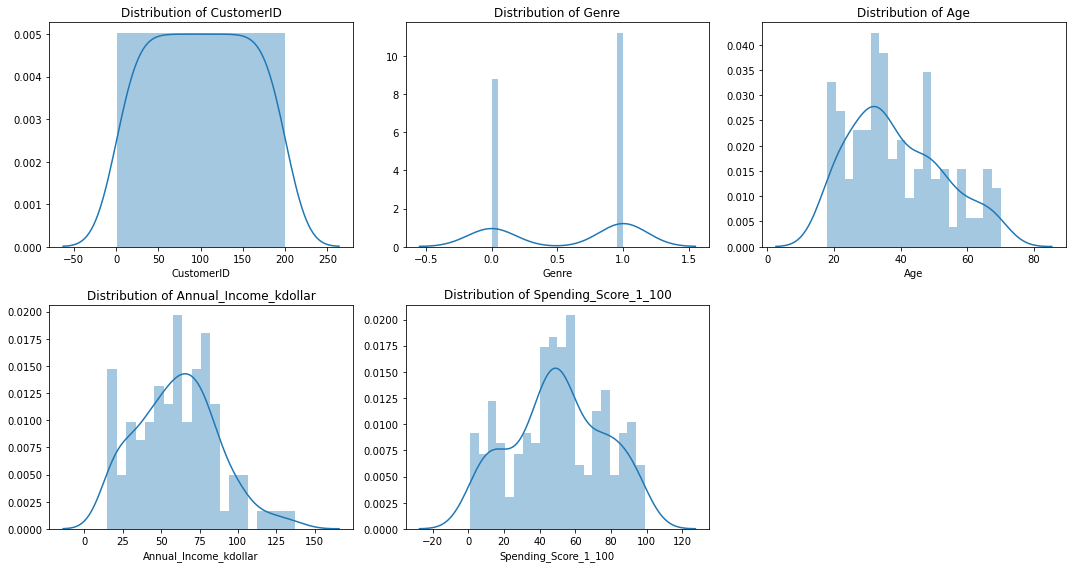

In [69]:
# Plot distributions of numerical features
num_cols=df.select_dtypes(include=['int64','float64']).columns
n_cols=len(num_cols)
n_rows=math.ceil(n_cols/3)
plt.figure(figsize=(15,4*n_rows))
for i,column in enumerate(num_cols):
    plt.subplot(n_rows,3,i + 1)
    sns.distplot(df[column],kde=True,bins=20)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

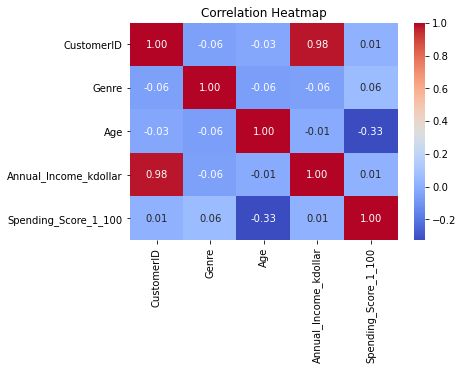

In [70]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

-Spending Score and Annual Income are not strongly related

-Age has weak negative correlation with Spending Score

->PCA might help uncover hidden structure by combining features.

**PRINCIPAL COMPONENT ANALYSIS**

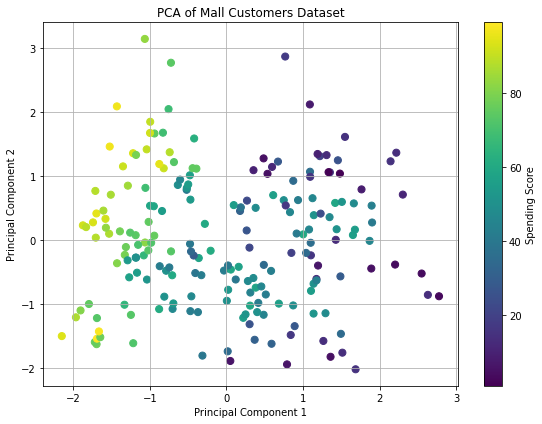

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Select features for PCA
features=['Genre','Age','Annual_Income_kdollar','Spending_Score_1_100']
X=df[features]

# Standardize the features
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

# Apply PCA
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X_scaled)

# Create a scatter plot colored by Spending Score
plt.figure(figsize=(8,6))
scatter=plt.scatter(X_pca[:,0],X_pca[:,1],c=df['Spending_Score_1_100'],cmap='viridis',s=50)
plt.colorbar(scatter,label='Spending Score')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Mall Customers Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

**K-MEANS CLUSTERING**

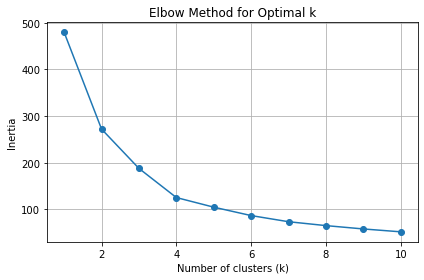

In [72]:
from sklearn.cluster import KMeans

# Determine optimal number of clusters using elbow method
inertia=[]
k_range=range(1, 11)
for k in k_range:
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(6,4))
plt.plot(k_range,inertia,marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
# Apply KMeans with optimal k=5
optimal_k=5
kmeans=KMeans(n_clusters=optimal_k,random_state=42)
clusters=kmeans.fit_predict(X_pca)

# Add cluster labels to original dataframe
df['Cluster']=clusters

# Analyze clusters
cluster_profiles=df.groupby('Cluster').mean().round(2)
print(cluster_profiles[['Genre','Age','Annual_Income_kdollar','Spending_Score_1_100']])

         Genre    Age  Annual_Income_kdollar  Spending_Score_1_100
Cluster                                                           
0         0.90  40.33                  50.64                 42.76
1         0.75  55.29                  42.33                 23.38
2         0.18  29.91                  81.50                 73.88
3         0.84  26.76                  49.58                 72.48
4         0.16  47.88                  74.38                 30.94


Analyzing clusters:  
Considering annual income >80k is high and <40k is low, spending score >60 is high and <40 is low:  
-Cluster 0: group of middle age females with average income and average spending score -> general customers  
-Cluster 1: group of middle age people in which 3/4 are females with average income and low spending score -> budget-concious customers  
-Cluster 2: group of young males with high income and high spending score -> ideal customers  
-Cluster 3: group of young females with average income and high spending score -> ideal customers  
-Cluster 4: group of middle age males with average income and low spending score -> budget-concious customers

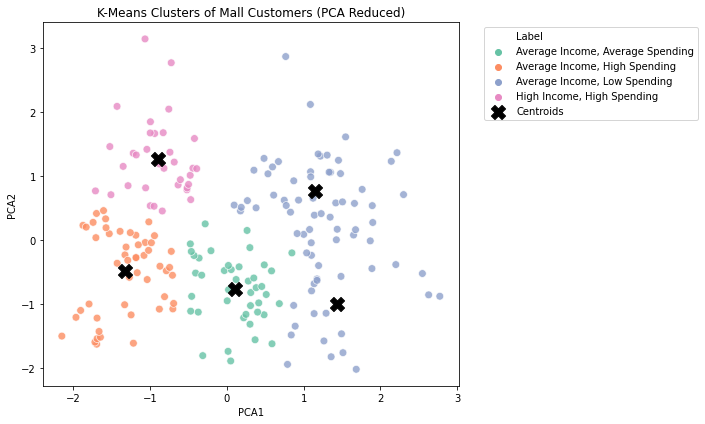

In [74]:
# Define descriptive labels for clusters (based on earlier analysis)
cluster_labels={
    0: "Average Income, Average Spending",
    1: "Average Income, Low Spending",
    2: "High Income, High Spending",
    3: "Average Income, High Spending",
    4: "Average Income, Low Spending"}
pca_df["Label"] = pca_df["Cluster"].map(cluster_labels)

# Plot the clusters with centroids
plt.figure(figsize=(10,6))
sns.scatterplot(data=pca_df,x="PCA1",y="PCA2",hue="Label",palette="Set2",s=60,alpha=0.8)

# Plot cluster centers in PCA space
centers_pca=kmeans.cluster_centers_
plt.scatter(centers_pca[:,0],centers_pca[:,1],c='black',s=200,marker='X',label='Centroids')

plt.title("K-Means Clusters of Mall Customers (PCA Reduced)")
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.tight_layout()
plt.show()

**CONCLUSION**

Performing K-means clustering algorithm is essential in segmenting customers into different categories, which helps us provide different marketing tactics depending on the groups:  
-Average income, average spending: educate about product benefits to increase basket size, offer seasonal promotions or referral incentives, use email campaigns to build brand loyalty  
-Average income, high spending: highlight value-for-money deals and bundles, use loyalty rewards to encourage continued spending, upsell mid-tier products with perceived high value  
-Average income, low spending: provide first-time buyer discounts or free trials, use retargeting ads to re-engage, highlight low-cost, high-utility products  
-High income, high spending: offer exclusive VIP programs or early access to new products, promote luxury or high-end product lines, personalized concierge services or premium support